<a href="https://colab.research.google.com/github/s20488/PJN/blob/main/Anastasiia_Ponkratova_Klasyfikacja_tekstu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 30.1 MB/s eta 0:00:00


# Klasyfikacja tekst z wykorzystaniem sentence-transformers i pytorch-lightning


### Zadanie 1 -  zbiór danych

In [ ]:
!wget https://raw.githubusercontent.com/sebischair/NLU-Evaluation-Corpora/master/WebApplicationsCorpus.json

--2024-11-30 00:00:31--  https://raw.githubusercontent.com/sebischair/NLU-Evaluation-Corpora/master/WebApplicationsCorpus.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 120374 (118K) [text/plain]
Saving to: ‘WebApplicationsCorpus.json’

WebApplicationsCorp 100%[===================>] 117.55K  --.-KB/s    in 0.02s   

2024-11-30 00:00:32 (6.82 MB/s) - ‘WebApplicationsCorpus.json’ saved [120374/120374]



In [ ]:
!cat WebApplicationsCorpus.json

{
	"name": "WebApplicationsCorpus",
	"desc": "Visit https://github.com/sebischair/NLU-Evaluation-Corpora for more information",
	"lang": "en",
    "sentences": [
        {
            "author": "Evan Plaice",
            "url": "http://webapps.stackexchange.com/questions/1912/alternative-to-facebook",
            "text": "Alternative to Facebook",
            "entities": [
                {
                    "text": "Facebook",
                    "entity": "WebService",
                    "stop": 2,
                    "start": 2
                }
            ],
            "intent": "Find Alternative",
            "answer": {
                "text": "<p><a href=\"https://plus.google.com/\">Google+</a>?</p>\n",
                "author": "Alex"
            },
            "training": false
        },
        {
            "author": "Ivo Flipse",
            "url": "http://webapps.stackexchange.com/questions/1/how-do-i-delete-my-facebook-account",
            "text": "How do I delete 

In [ ]:
from torch.utils.data import Dataset
import numpy as np

In [ ]:
class IntentDataset():
  def __init__(self, texts, intents, classes):
    self.classes = classes
    self.texts = np.array(texts)
    self.intents = np.array(intents)
  def __getitem__(self, idx):
    x = self.texts[idx]
    y = self.classes.index(self.intents[idx])

    return x, y


  def __len__(self):
    return (len(self.texts))



In [ ]:
 import pytorch_lightning as pl
 import json
 from torch.utils.data import DataLoader

In [ ]:
class IntentDataModule(pl.LightningDataModule):
  def __init__(self, filepath, batch_size = 32):
    super().__init__()
    self.filepath = filepath
    self.batch_size = batch_size



  def prepare_data(self):
    with open(self.filepath, 'r') as f:
        self.data = json.load(f)

  def setup(self, stage = None):
    # podziel zbiór na treningowy i testowy na podstawie parametru "training" w jsonie
    sentences = self.data['sentences']
    texts = [sentence['text'] for sentence in sentences]
    intents = [sentence['intent'] for sentence in sentences]
    training = [sentence['training'] for sentence in sentences]

    # wczytaj zdania jako x a intencje jako y
    X_train = [texts[i] for i in range(len(texts)) if training[i]]
    y_train = [intents[i] for i in range(len(intents)) if training[i]]
    X_test = [texts[i] for i in range(len(texts)) if not training[i]]
    y_test = [intents[i] for i in range(len(intents)) if not training[i]]

    # stwórz listę klas (unikatowych intencji)

    self.classes = list(set(intents))

    self.train_dataset = IntentDataset(X_train, y_train, self.classes)
    self.val_dataset = IntentDataset(X_test, y_test, self.classes)


  def train_dataloader(self):
    return DataLoader(self.train_dataset, batch_size = self.batch_size)

  def val_dataloader(self):
    return DataLoader(self.val_dataset, batch_size = self.batch_size)


In [ ]:
dm = IntentDataModule("/content/WebApplicationsCorpus.json")

In [ ]:
dm.prepare_data()

In [ ]:
dm.setup()

In [ ]:
next(iter(dm.train_dataloader()))

[('How do I download a YouTube video?',
  'How do I change my password on TV Tropes?',
  "Why can't I change my password and login with Skype?",
  'Change subject line in new Gmail compose window',
  'Email Google Form daily?',
  'How can I export track.scrobble data from last.fm?',
  'How can I backup my wordpress.com hosted blog?',
  'How can I sync my Yahoo! Calendar with Google Calendar?',
  'Google Bookmarks and Chrome Bookmark Sync -- Different?',
  'How do I sync my RunKeeper workout schedule with Google Calender?',
  'Does using Gmail\'s "Never send it to Spam" filter mean I can\'t train their spam filter?',
  'Correctly Identifying Spam Messages',
  'Twitter and Echofon spam',
  'Totally Blocking Spam To Gmail Account',
  'Discarding spam mail faster in Gmail',
  'Stopping spam emails in Gmail by pattern',
  'Alternatives for Google Reader (with Android synchronizing)',
  "Bugmenot (registration bypasser) alternative that doesn't suck?",
  'Alternatives to Twitter',
  'Google 

### Zadanie 2 - model

In [ ]:
!pip install sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer
from torch import nn

In [ ]:
st_model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/11.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Enkoder zamieniający text na wektor

In [ ]:
sentence_vector = st_model.encode(["siała baba mak"], convert_to_numpy = False, convert_to_tensor = True)

In [ ]:
sentence_vector

tensor([[-7.0883e-02,  8.8295e-02, -7.6458e-02,  7.7186e-02, -6.7930e-03,
         -6.0612e-02,  2.6715e-02, -5.2551e-02, -2.0462e-02, -3.9397e-02,
          5.4174e-02, -5.0411e-02, -3.4368e-03,  1.0284e-02,  3.7899e-02,
          6.4783e-02, -1.1631e-03,  6.2795e-02,  6.1397e-02, -4.5762e-02,
          2.4166e-02, -4.9520e-02,  1.7833e-02,  8.7638e-03,  1.1596e-02,
         -3.8035e-02,  2.6718e-02,  1.5561e-02,  5.6304e-02, -7.8390e-02,
         -1.6254e-02,  3.8066e-02,  2.0986e-02, -7.6386e-03,  9.9156e-03,
          1.3999e-01, -3.2134e-02,  1.3720e-02, -3.2888e-02,  2.6900e-03,
          1.0144e-01, -9.0574e-03,  6.3754e-02,  1.9680e-03, -1.0830e-02,
          1.0399e-02, -8.3134e-02,  4.0301e-02, -2.8897e-02, -5.5409e-02,
         -1.3284e-01, -4.3653e-02, -4.7532e-02, -6.2663e-03, -2.9475e-03,
         -1.1916e-01,  6.5366e-02,  6.4106e-02,  4.6354e-02,  3.1006e-03,
         -2.2405e-02,  1.3514e-02, -3.6752e-03,  2.6072e-02,  2.7928e-02,
         -5.4685e-02, -7.5703e-02, -7.

In [ ]:
sentence_vector.shape

torch.Size([1, 384])

Zaimplementuj model detekcji intecji na podstawie enkodera z sentence transformers

In [ ]:
from torch.optim import Adam

In [ ]:
import torchmetrics

In [ ]:
import torch

In [ ]:
class IntentModel(pl.LightningModule):

  def __init__(self, encoder_name, num_classes):

    super().__init__()

    #zainincjalizuj encoder używając modelu z sentence transformers o podanej nazwie
    self.encoder = SentenceTransformer(encoder_name)

    # zaimplementuj warstwy klasyfikacyjne
    self.fc1 = torch.nn.Linear(self.encoder.get_sentence_embedding_dimension(), num_classes)

    self.train_acc = torchmetrics.Accuracy(task = "multiclass", num_classes = num_classes)
    self.valid_acc = torchmetrics.Accuracy(task = "multiclass", num_classes = num_classes)



  def forward(self,x):
    # TODO
    x = self.encoder.encode(x, convert_to_numpy = False, convert_to_tensor = True)
    x = self.fc1(x)

    return x

  def training_step(self, batch):
    #TODO
    x, y = batch
    preds = self(x)
    loss = torch.nn.functional.cross_entropy(preds, y)
    self.train_acc(preds, y)
    self.log('train_acc', self.train_acc, on_step=True, on_epoch=True, prog_bar=True)
    return loss


  def validation_step(self, batch, batch_idx):
    #TODO
    x, y = batch
    preds = self(x)
    loss = torch.nn.functional.cross_entropy(preds, y)
    self.valid_acc(preds, y)
    self.log("val_acc", self.valid_acc, on_step=True, on_epoch=True, prog_bar=True)
    return loss


  def configure_optimizers(self):
    return Adam(self.parameters())



In [ ]:
model = IntentModel('all-MiniLM-L6-v2', len(dm.classes))

In [ ]:
from pytorch_lightning import Trainer

In [ ]:
trainer  = Trainer(max_epochs = 40)
trainer.fit(model,dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | encoder   | SentenceTransformer | 22.7 M | train
1 | fc1       | Linear              | 3.1 K  | train
2 | train_acc | MulticlassAccuracy  | 0      | train
3 | valid_acc | MulticlassAccuracy  | 0      | train
----------------------------------------------------------
22.7 M    Trainable params
0         Non-trainable params
22.7 M    Total params
90.865    Total estimated model params size (MB)
7         Modules in train mode
120       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.


### Zadanie 3 - porównanie modeli


Dla tej samej architektury porównaj co najmniej 3 modele z https://www.sbert.net/docs/pretrained_models.html



Będziemy zapisywać najlepszą wersje modelu używając [callbacków](https://pytorch-lightning.readthedocs.io/en/stable/extensions/callbacks.html)  - specjalnych funkcji które wykoryszywane są podczas treningu do jego monitorowania

W naszym przypadku użujemy callbacku ModelCheckpoint wbudowanego w pytorch lightninga służącego do zapisywania najepszej wersji modelu na podstawie danej metryki


In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint

Stwóż callback który będzie monitorować parametr skuteczności na zbiorze walidacyjnym - pamiętaj aby ustawić parametr `mode` który reguluje czy będziemy metryke maksymalizować czy minimalizować.


In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_acc',
    mode='max',
    save_top_k=1,
    verbose=True
)

Callbalk przekazywany jest jako parametr Trainera

In [ ]:
trainer = pl.Trainer(max_epochs=40, callbacks=[checkpoint_callback])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


model zapisany będzie w katalogu `lightning_logs/<wersja_modelu>/checkpoints/<najlepsza epoka>.ckpt`

In [ ]:
trainer.fit(model,dm)

INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                | Params | Mode
---------------------------------------------------------
0 | encoder   | SentenceTransformer | 22.7 M | eval
1 | fc1       | Linear              | 3.1 K  | eval
2 | train_acc | MulticlassAccuracy  | 0      | eval
3 | valid_acc | MulticlassAccuracy  | 0      | eval
---------------------------------------------------------
22.7 M    Trainable params
0         Non-trainable params
22.7 M    Total params
90.865    Total estimated model params size (MB)
0         Modules in train mode
127       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 1: 'val_acc' reached 0.88136 (best 0.88136), saving model to '/content/lightning_logs/version_9/checkpoints/epoch=0-step=1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 2: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 3: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 4: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 5: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 6: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 7: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 8: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 9: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 10: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 11: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 12: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 13: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 14: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 15: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 16: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 17: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 18: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 19: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 20: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 21: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 21, global step 22: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 22, global step 23: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 23, global step 24: 'val_acc' reached 0.89831 (best 0.89831), saving model to '/content/lightning_logs/version_9/checkpoints/epoch=23-step=24.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 24, global step 25: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 25, global step 26: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 26, global step 27: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 27, global step 28: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 28, global step 29: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 29, global step 30: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 30, global step 31: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 31, global step 32: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 32, global step 33: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 33, global step 34: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 34, global step 35: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 35, global step 36: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 36, global step 37: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 37, global step 38: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 38, global step 39: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 39, global step 40: 'val_acc' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.


Możemy potem załadować najlepszą wersje modelu używając funkcji `load_from_checkpoint` podająć ścierzkę do checkpointu i parametry modelu (z funkcji __init__)

In [ ]:
model = IntentModel.load_from_checkpoint("/content/lightning_logs/version_9/checkpoints/epoch=23-step=24.ckpt",encoder_name = 'all-MiniLM-L6-v2', num_classes = len(dm.classes))

Potem możemy przetesować model używając funkcji validate

In [ ]:
trainer.validate(model,dm)

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.8983050584793091     │
└───────────────────────────┴───────────────────────────┘

[{'val_acc_epoch': 0.8983050584793091}]

Wybierz 3 enkodery z biblioteki sentence_transformers, wytrenuj modele na ich podstawie i porównaj wyniki, wyniki przedstaw w postaci wykresu słupkowego https://www.geeksforgeeks.org/bar-plot-in-matplotlib/


In [ ]:
encoders = ['all-MiniLM-L12-v2', 'all-distilroberta-v1', 'multi-qa-distilbert-cos-v1']
results = {}

In [ ]:
for encoder in encoders:
    model = IntentModel(encoder_name=encoder, num_classes=len(dm.classes))
    checkpoint_callback = ModelCheckpoint(monitor='val_acc', mode='max', save_top_k=1, verbose=True)
    trainer = pl.Trainer(max_epochs=40, callbacks=[checkpoint_callback])
    trainer.fit(model, dm)
    results[encoder] = trainer.callback_metrics['val_acc'].item()

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | encoder   | SentenceTransformer | 33.4 M | train
1 | fc1       | Linear              | 3.1 K  | train
2 | train_acc | MulticlassAccuracy  | 0      | train
3 | valid_acc | MulticlassAccuracy  | 0      | train
----------------------------------------------------------
33.4 M    Trainable params
0         Non-trainable params
33.4 M    Total params
133.452   Total estimated model params size (MB)
7         Modules in train mode
228       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 1: 'val_acc' reached 0.28814 (best 0.28814), saving model to '/content/lightning_logs/version_10/checkpoints/epoch=0-step=1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 2: 'val_acc' reached 0.30508 (best 0.30508), saving model to '/content/lightning_logs/version_10/checkpoints/epoch=1-step=2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 3: 'val_acc' reached 0.33898 (best 0.33898), saving model to '/content/lightning_logs/version_10/checkpoints/epoch=2-step=3.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 4: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 5: 'val_acc' reached 0.38983 (best 0.38983), saving model to '/content/lightning_logs/version_10/checkpoints/epoch=4-step=5.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 6: 'val_acc' reached 0.44068 (best 0.44068), saving model to '/content/lightning_logs/version_10/checkpoints/epoch=5-step=6.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 7: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 8: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 9: 'val_acc' reached 0.45763 (best 0.45763), saving model to '/content/lightning_logs/version_10/checkpoints/epoch=8-step=9.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 10: 'val_acc' reached 0.47458 (best 0.47458), saving model to '/content/lightning_logs/version_10/checkpoints/epoch=9-step=10.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 11: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 12: 'val_acc' reached 0.50847 (best 0.50847), saving model to '/content/lightning_logs/version_10/checkpoints/epoch=11-step=12.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 13: 'val_acc' reached 0.54237 (best 0.54237), saving model to '/content/lightning_logs/version_10/checkpoints/epoch=12-step=13.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 14: 'val_acc' reached 0.55932 (best 0.55932), saving model to '/content/lightning_logs/version_10/checkpoints/epoch=13-step=14.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 15: 'val_acc' reached 0.57627 (best 0.57627), saving model to '/content/lightning_logs/version_10/checkpoints/epoch=14-step=15.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 16: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 17: 'val_acc' reached 0.64407 (best 0.64407), saving model to '/content/lightning_logs/version_10/checkpoints/epoch=16-step=17.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 18: 'val_acc' reached 0.66102 (best 0.66102), saving model to '/content/lightning_logs/version_10/checkpoints/epoch=17-step=18.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 19: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 20: 'val_acc' reached 0.67797 (best 0.67797), saving model to '/content/lightning_logs/version_10/checkpoints/epoch=19-step=20.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 21: 'val_acc' reached 0.69492 (best 0.69492), saving model to '/content/lightning_logs/version_10/checkpoints/epoch=20-step=21.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 21, global step 22: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 22, global step 23: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 23, global step 24: 'val_acc' reached 0.71186 (best 0.71186), saving model to '/content/lightning_logs/version_10/checkpoints/epoch=23-step=24.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 24, global step 25: 'val_acc' reached 0.72881 (best 0.72881), saving model to '/content/lightning_logs/version_10/checkpoints/epoch=24-step=25.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 25, global step 26: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 26, global step 27: 'val_acc' reached 0.74576 (best 0.74576), saving model to '/content/lightning_logs/version_10/checkpoints/epoch=26-step=27.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 27, global step 28: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 28, global step 29: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 29, global step 30: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 30, global step 31: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 31, global step 32: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 32, global step 33: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 33, global step 34: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 34, global step 35: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 35, global step 36: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 36, global step 37: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 37, global step 38: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 38, global step 39: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 39, global step 40: 'val_acc' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.3k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | encoder   | SentenceTransformer | 82.1 M | train
1 | fc1       | Linear              | 6.2 K  | train
2 | train_acc | MulticlassAccuracy  | 0      | train
3 | valid_acc | MulticlassAccuracy  | 0      | train
----------------------------------------------------------
82.1 M    Trainable params
0         Non-trainable params
82.1 M    Total params
328.498   Total estimated model params size (MB)
7         Modules in train mode
120       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 1: 'val_acc' reached 0.13559 (best 0.13559), saving model to '/content/lightning_logs/version_11/checkpoints/epoch=0-step=1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 2: 'val_acc' reached 0.25424 (best 0.25424), saving model to '/content/lightning_logs/version_11/checkpoints/epoch=1-step=2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 3: 'val_acc' reached 0.42373 (best 0.42373), saving model to '/content/lightning_logs/version_11/checkpoints/epoch=2-step=3.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 4: 'val_acc' reached 0.62712 (best 0.62712), saving model to '/content/lightning_logs/version_11/checkpoints/epoch=3-step=4.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 5: 'val_acc' reached 0.66102 (best 0.66102), saving model to '/content/lightning_logs/version_11/checkpoints/epoch=4-step=5.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 6: 'val_acc' reached 0.69492 (best 0.69492), saving model to '/content/lightning_logs/version_11/checkpoints/epoch=5-step=6.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 7: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 8: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 9: 'val_acc' reached 0.71186 (best 0.71186), saving model to '/content/lightning_logs/version_11/checkpoints/epoch=8-step=9.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 10: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 11: 'val_acc' reached 0.74576 (best 0.74576), saving model to '/content/lightning_logs/version_11/checkpoints/epoch=10-step=11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 12: 'val_acc' reached 0.76271 (best 0.76271), saving model to '/content/lightning_logs/version_11/checkpoints/epoch=11-step=12.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 13: 'val_acc' reached 0.77966 (best 0.77966), saving model to '/content/lightning_logs/version_11/checkpoints/epoch=12-step=13.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 14: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 15: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 16: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 17: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 18: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 19: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 20: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 21: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 21, global step 22: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 22, global step 23: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 23, global step 24: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 24, global step 25: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 25, global step 26: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 26, global step 27: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 27, global step 28: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 28, global step 29: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 29, global step 30: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 30, global step 31: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 31, global step 32: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 32, global step 33: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 33, global step 34: 'val_acc' reached 0.79661 (best 0.79661), saving model to '/content/lightning_logs/version_11/checkpoints/epoch=33-step=34.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 34, global step 35: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 35, global step 36: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 36, global step 37: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 37, global step 38: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 38, global step 39: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 39, global step 40: 'val_acc' reached 0.81356 (best 0.81356), saving model to '/content/lightning_logs/version_11/checkpoints/epoch=39-step=40.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/9.52k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/523 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | encoder   | SentenceTransformer | 66.4 M | train
1 | fc1       | Linear              | 6.2 K  | train
2 | train_acc | MulticlassAccuracy  | 0      | train
3 | valid_acc | MulticlassAccuracy  | 0      | train
----------------------------------------------------------
66.4 M    Trainable params
0         Non-trainable params
66.4 M    Total params
265.476   Total estimated model params size (MB)
7         Modules in train mode
92        Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 1: 'val_acc' reached 0.20339 (best 0.20339), saving model to '/content/lightning_logs/version_12/checkpoints/epoch=0-step=1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 2: 'val_acc' reached 0.37288 (best 0.37288), saving model to '/content/lightning_logs/version_12/checkpoints/epoch=1-step=2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 3: 'val_acc' reached 0.49153 (best 0.49153), saving model to '/content/lightning_logs/version_12/checkpoints/epoch=2-step=3.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 4: 'val_acc' reached 0.66102 (best 0.66102), saving model to '/content/lightning_logs/version_12/checkpoints/epoch=3-step=4.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 5: 'val_acc' reached 0.71186 (best 0.71186), saving model to '/content/lightning_logs/version_12/checkpoints/epoch=4-step=5.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 6: 'val_acc' reached 0.76271 (best 0.76271), saving model to '/content/lightning_logs/version_12/checkpoints/epoch=5-step=6.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 7: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 8: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 9: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 10: 'val_acc' reached 0.79661 (best 0.79661), saving model to '/content/lightning_logs/version_12/checkpoints/epoch=9-step=10.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 11: 'val_acc' reached 0.81356 (best 0.81356), saving model to '/content/lightning_logs/version_12/checkpoints/epoch=10-step=11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 12: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 13: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 14: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 15: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 16: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 17: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 18: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 19: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 20: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 21: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 21, global step 22: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 22, global step 23: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 23, global step 24: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 24, global step 25: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 25, global step 26: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 26, global step 27: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 27, global step 28: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 28, global step 29: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 29, global step 30: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 30, global step 31: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 31, global step 32: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 32, global step 33: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 33, global step 34: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 34, global step 35: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 35, global step 36: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 36, global step 37: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 37, global step 38: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 38, global step 39: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 39, global step 40: 'val_acc' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.


In [ ]:
import matplotlib.pyplot as plt

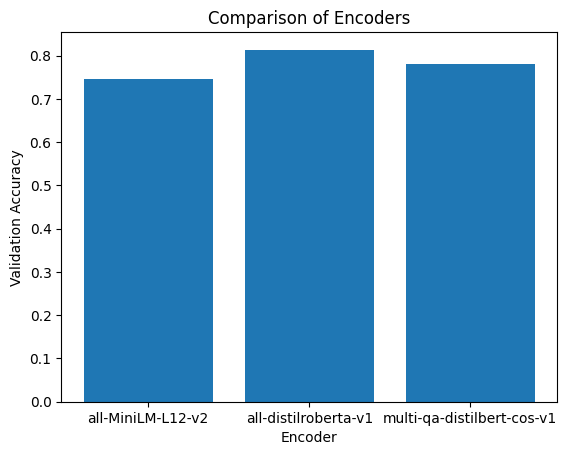

In [ ]:
plt.bar(results.keys(), results.values())
plt.xlabel('Encoder')
plt.ylabel('Validation Accuracy')
plt.title('Comparison of Encoders')
plt.show()